In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import holidays
sns.set_theme()
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [2]:
df = pd.read_parquet('../data_export/prueba_ml.parquet')
df.reset_index(inplace=True, drop=True)
df['dia_semana'] = df['fecha'].dt.weekday + 1
year = 2023
us_holidays = holidays.US(years=year)
us_holidays
df['holiday'] = np.where(df['fecha'].isin(us_holidays), 1, 0)
df['rain'] = df['rain'].shift(1)
df['snowfall'] = df['snowfall'].shift(1)
df.fillna(0.0, inplace=True)
df['datetime'] = pd.to_datetime(df['fecha'].astype(str) + ' ' + df['hora'].astype(int).astype(str) + ':00:00')
df.drop(columns='fecha', inplace=True)
df.set_index('datetime', inplace=True)
df.head()

,hora,temperature_2m,rain,relative_humidity_2m,snowfall,Bronx,Brooklyn,Manhattan,Queens,Staten Island,año,mes,dia,dia_semana,holiday
datetime,,,,,,,,,,,,,,,
2023-11-01 00:00:00,0.0,8.6725,0.0,60.153034,0.0,3,12,2196,232,1,2023,11,1,3,0
2023-11-01 01:00:00,1.0,8.5725,0.1,60.344471,0.0,2,12,1521,55,0,2023,11,1,3,0
2023-11-01 02:00:00,2.0,8.3225,0.0,62.933163,0.0,3,8,1214,16,0,2023,11,1,3,0
2023-11-01 03:00:00,3.0,8.0725,0.1,66.100021,0.0,0,13,854,20,0,2023,11,1,3,0
2023-11-01 04:00:00,4.0,7.7725,0.0,72.938622,0.0,12,20,654,25,0,2023,11,1,3,0


In [5]:
def generar_modelos_cv(df, columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 
                                      'rain', 'relative_humidity_2m', 'snowfall'],
                        columnas_Y = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']):

    
    X = df[columnas_X]
    Y = df[columnas_Y]

    models = {}
    predictions = {}
    errors = {}
    # definimos el generador de splits
    tscv = TimeSeriesSplit(n_splits=5)

    # Definir los parámetros para la búsqueda de hiperparámetros
    param_grid = {
        'learning_rate': [0.05, 0.1, 0.2],
        'num_leaves': [31, 50, 100],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 500, 1000]
    }

    for district in columnas_Y:
        print('Inicio de evaluación de', district)
        X_train, X_test, y_train, y_test = train_test_split(X, Y[district], test_size=0.2, random_state=42, shuffle=False)

        # Inicializar el modelo LightGBM
        model = lgb.LGBMRegressor(verbosity=-1)

        # Realizar la búsqueda de hiperparámetros mediante GridSearchCV con TimeSeriesSplit
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=0)
        grid_search.fit(X_train, y_train)

        # Obtener el mejor modelo
        best_model = grid_search.best_estimator_
        models[district] = best_model

        best_params = grid_search.best_params_
        print('Mejores Hiperparámetros:', best_params)

        # Predecir los datos de prueba
        y_pred = best_model.predict(X_test)

        # Evaluar el modelo
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        errors[district] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

        print('RMSE:', rmse)

        predictions_df = pd.DataFrame({
            'Predicted': y_pred,
            'Real values': y_test
        }, index=y_test.index)

        predictions[district] = predictions_df

        print('-----------------------------------------------------------------------------------------')
    return models, predictions, errors


In [6]:
models, predictions, errors = generar_modelos_cv(df)

Inicio de evaluación de Bronx


Mejores Hiperparámetros: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
RMSE: 6.59782695988291
-----------------------------------------------------------------------------------------
Inicio de evaluación de Brooklyn
Mejores Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'num_leaves': 31}
RMSE: 28.24143867733718
-----------------------------------------------------------------------------------------
Inicio de evaluación de Manhattan
Mejores Hiperparámetros: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'num_leaves': 31}
RMSE: 1329.5598302289704
-----------------------------------------------------------------------------------------
Inicio de evaluación de Queens
Mejores Hiperparámetros: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 1000, 'num_leaves': 31}
RMSE: 134.6829166683959
-----------------------------------------------------------------------------------------
Inicio de evaluación de Staten 

In [9]:
def graficar_predicciones(predictions):
    for district, data in predictions.items():
        plt.figure(figsize=(20, 10))
        plt.plot(data['Real values'], label='Test Data', color='green')
        plt.plot(data['Predicted'], label='Predictions', color='red')
        plt.legend()
        plt.title(f'RandomForest Predictions for {district}')
        plt.xlabel('Date')
        plt.ylabel('Demand')
        plt.show()

In [10]:
def graficar_importancias(models, features= ['año', 'mes', 'dia', 'hora', 'dia_semana', 
                                             'holiday', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']):
    
    for district, model in models.items():
        feature_importances = pd.Series(model.feature_importances_, index=features)
        plt.figure(figsize=(5, 5))
        feature_importances.nlargest(10).plot(kind='barh')
        plt.title(f'Feature Importances in {district}')
        plt.show()

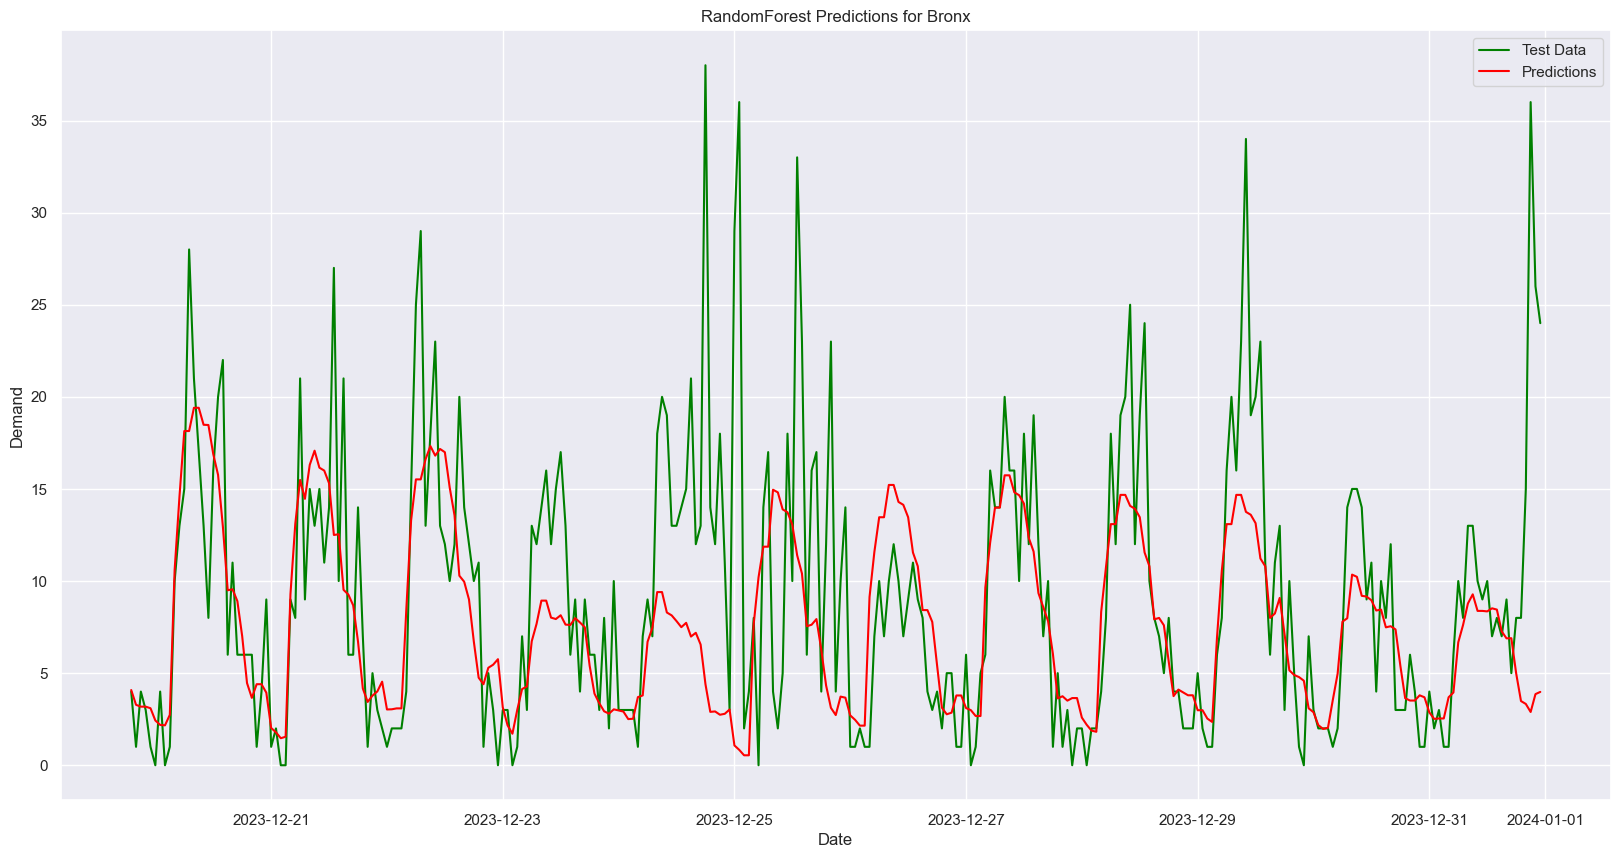

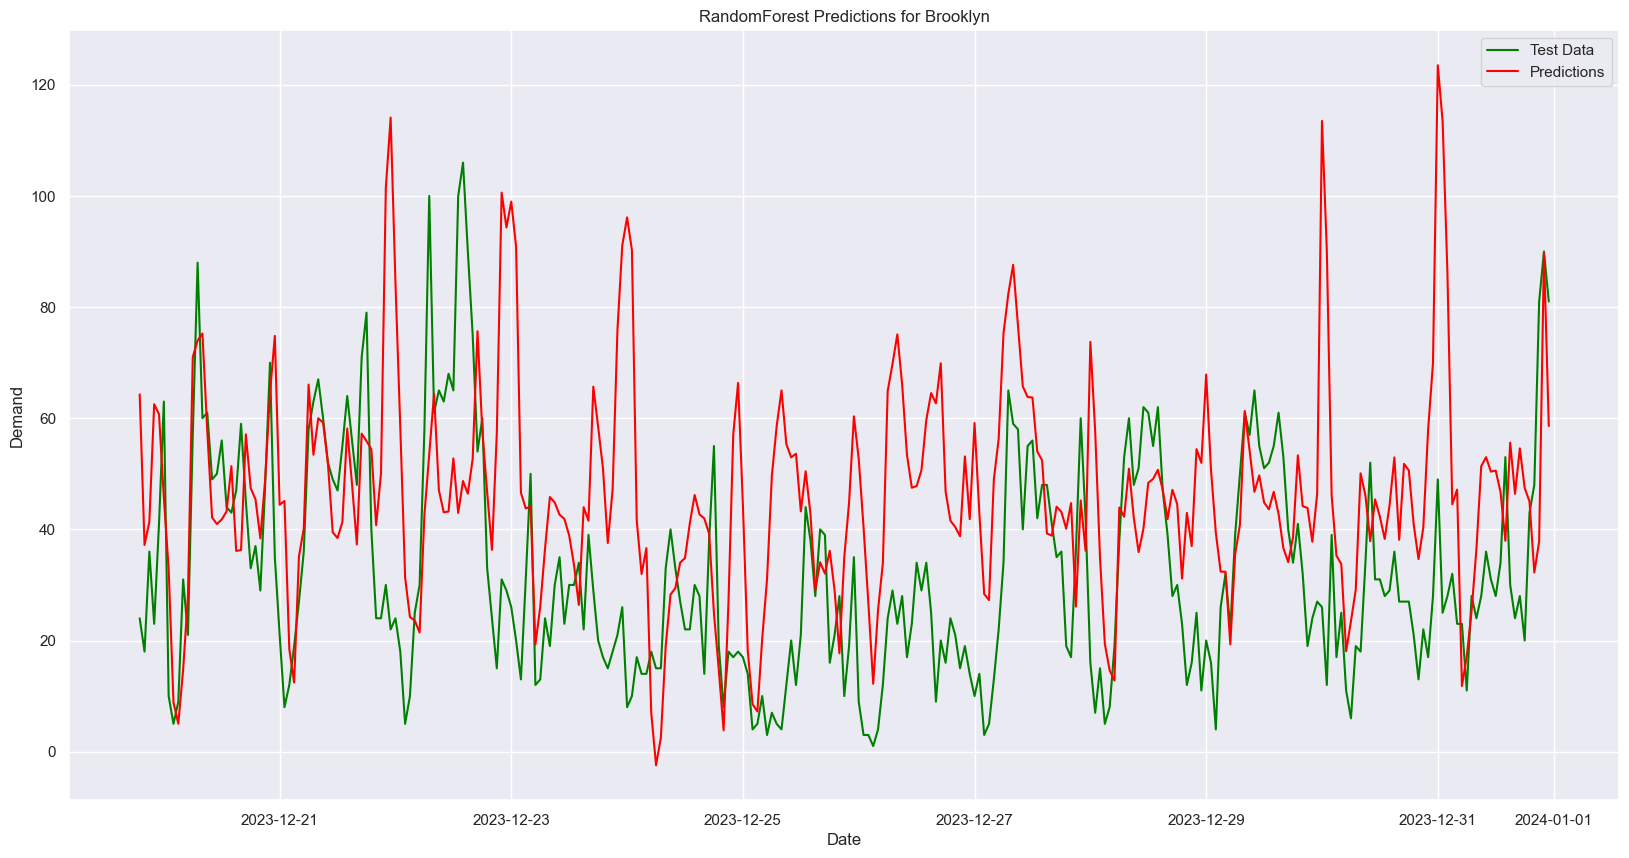

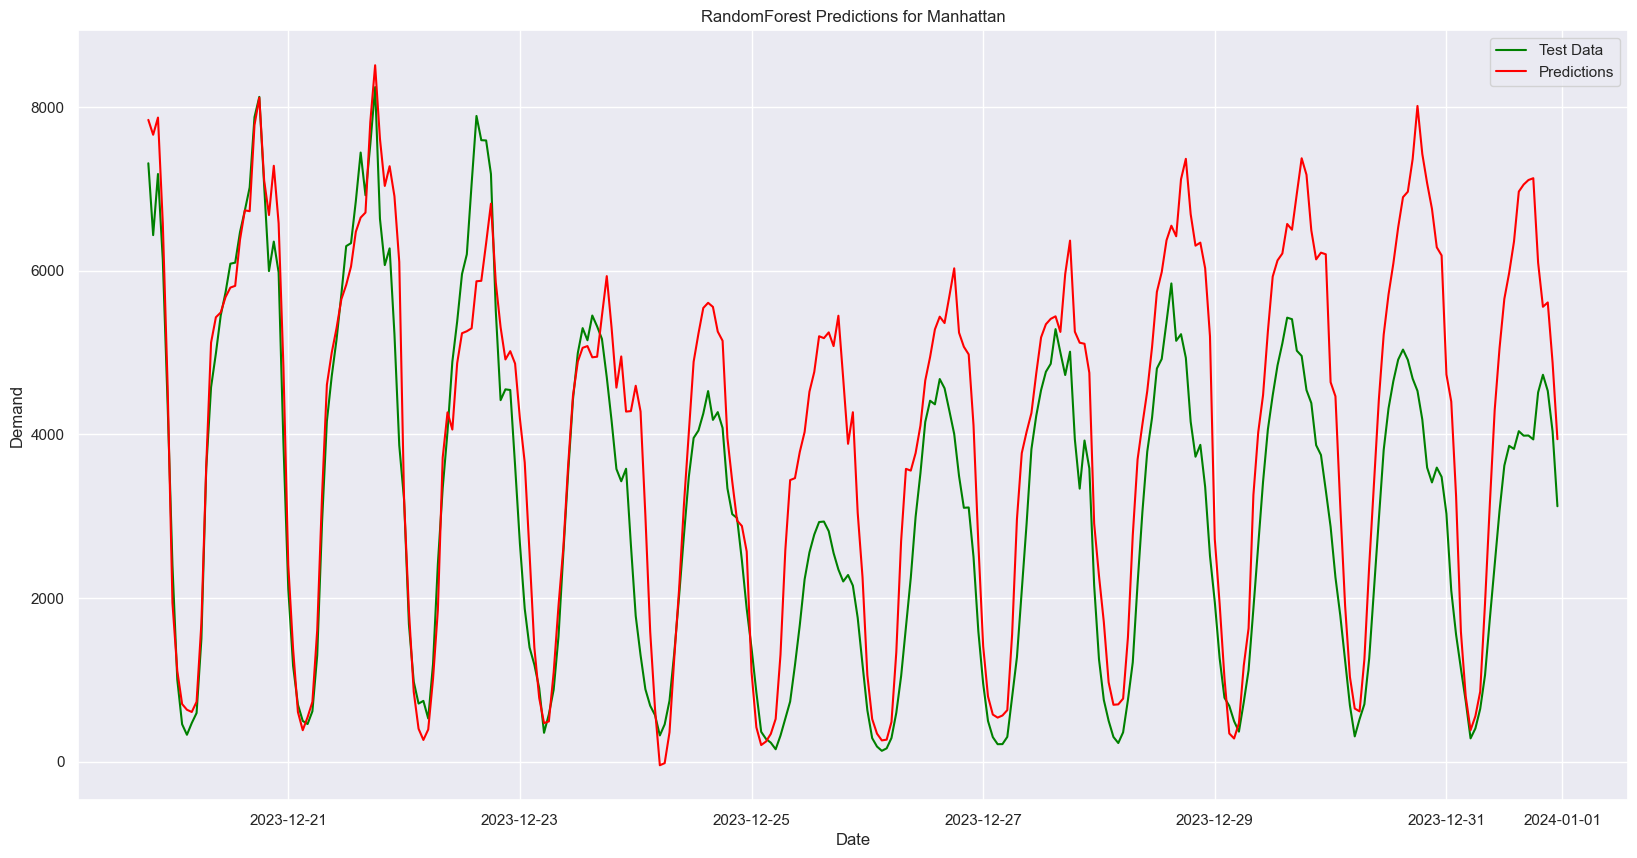

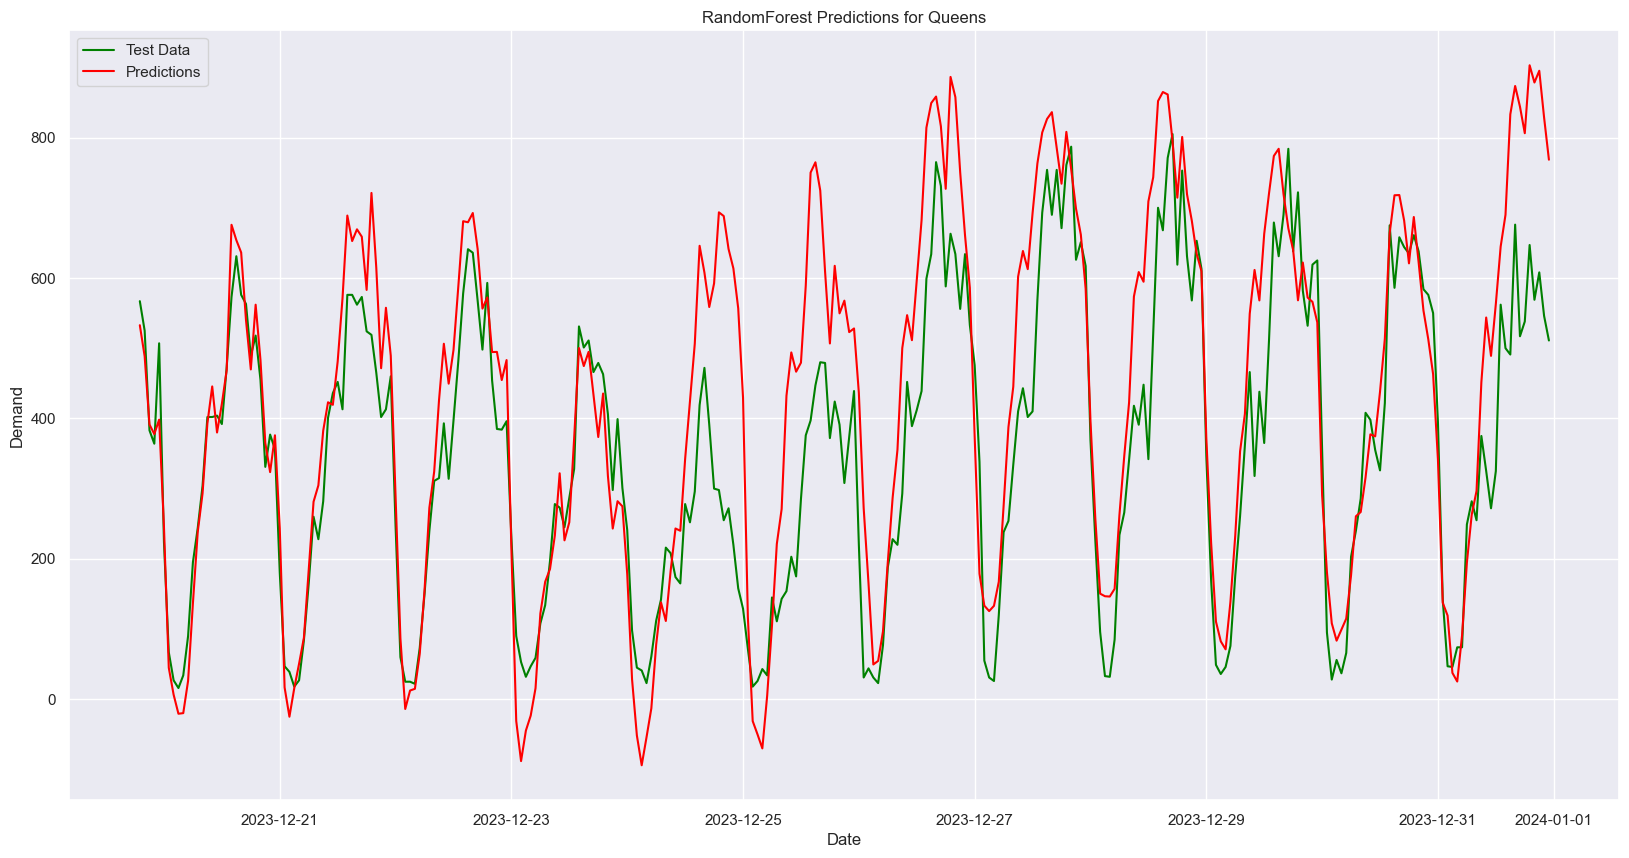

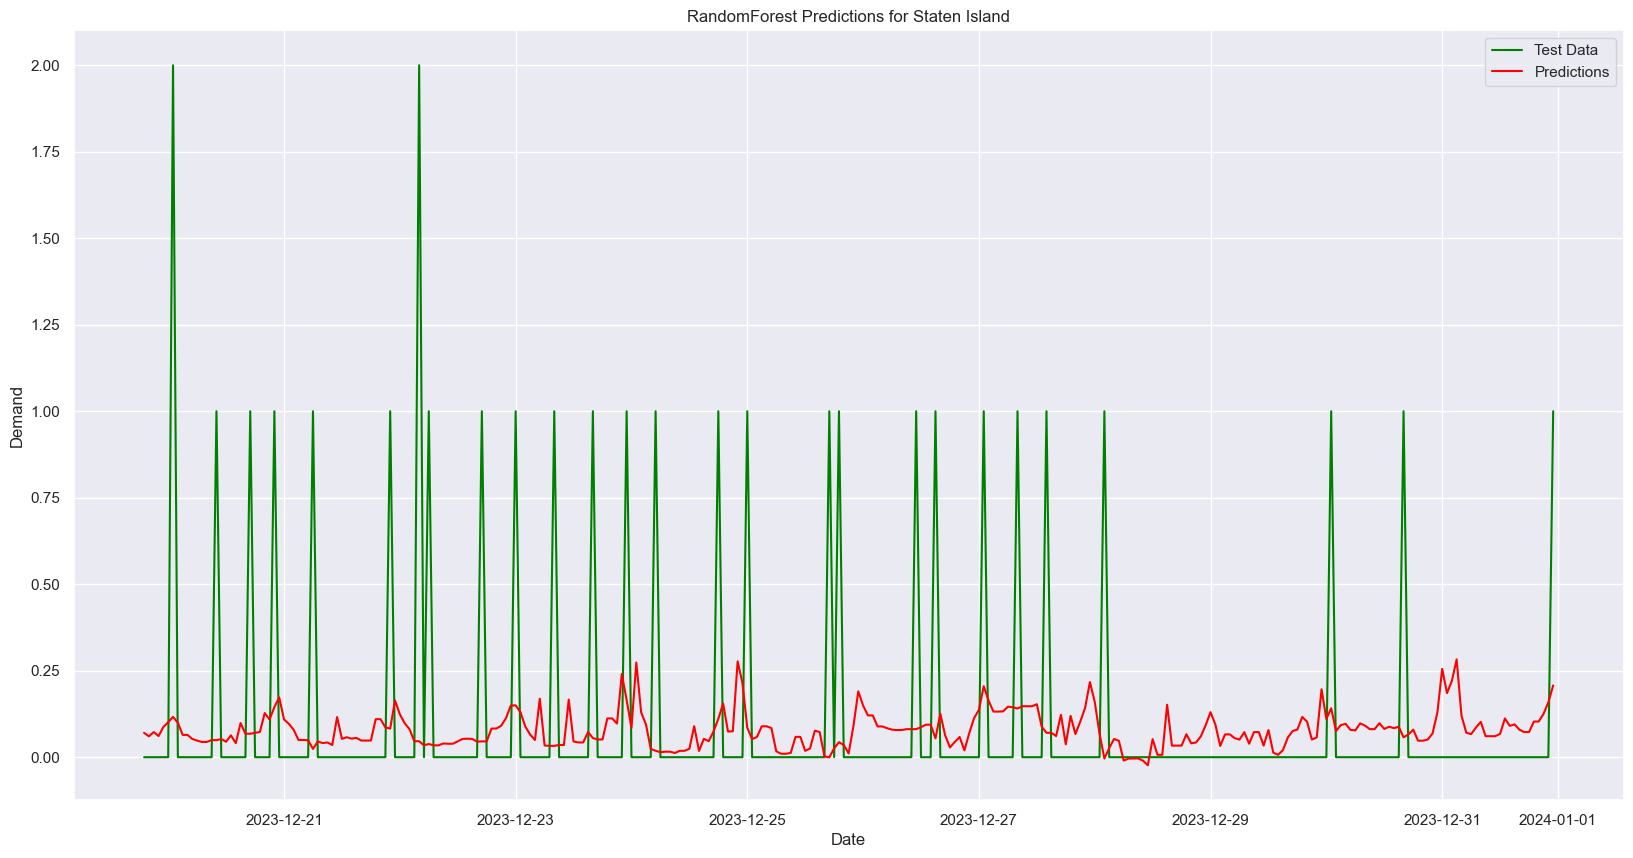

In [11]:
graficar_predicciones(predictions)

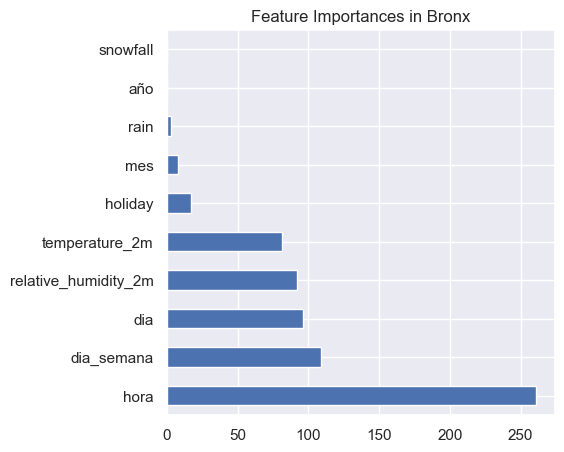

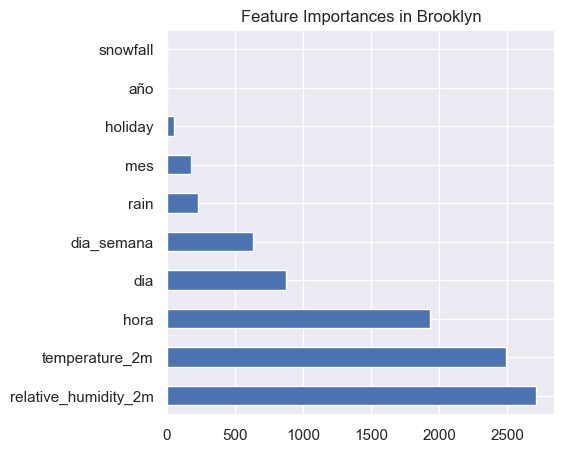

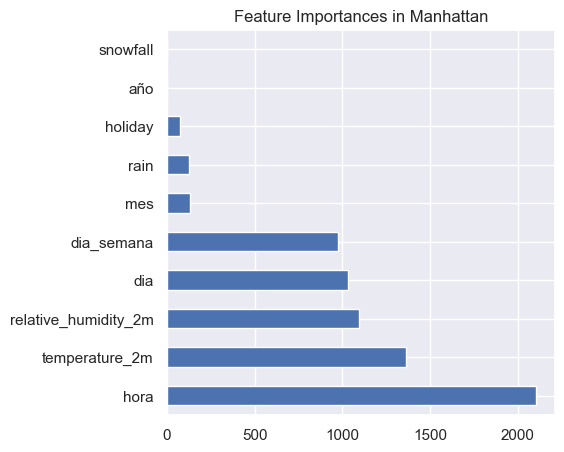

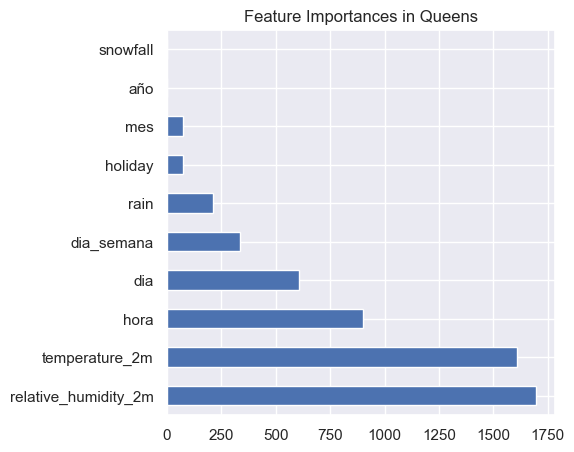

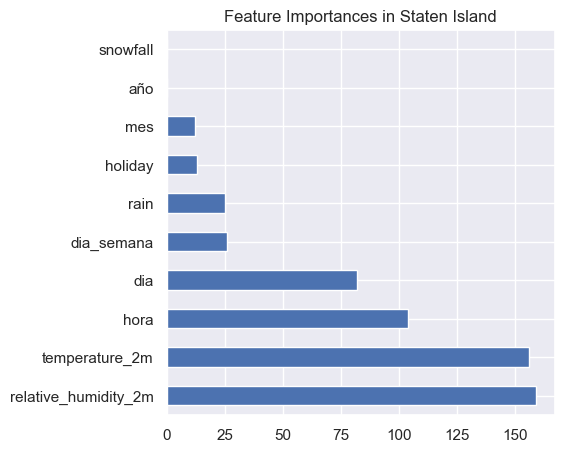

In [12]:
graficar_importancias(models)

In [14]:
for district in errors.keys():
    print(district, ':', errors[district]['RMSE'])

Bronx : 6.59782695988291
Brooklyn : 28.24143867733718
Manhattan : 1329.5598302289704
Queens : 134.6829166683959
Staten Island : 0.32420001283432814
